In [1]:
using Oceananigans
using Oceananigans.Units
using Oceananigans.OutputReaders: FieldTimeSeries

┌ Warning: You are using Julia v1.11 or later!"
│ Oceananigans is currently tested on Julia v1.10."
│ If you find issues with Julia v1.11 or later,"
│ please report at https://github.com/CliMA/Oceananigans.jl/issues/new
└ @ Oceananigans C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Oceananigans.jl:124


In [2]:
Lx = 1000kilometers # east-west extent [m]
Ly = 1000kilometers # north-south extent [m]
Lz = 1kilometers    # depth [m]

grid = RectilinearGrid(size = (48, 8),
                       y = (-Ly/2, Ly/2),
                       z = (-Lz, 0),
                       topology = (Flat, Bounded, Bounded))

1×48×8 RectilinearGrid{Float64, Flat, Bounded, Bounded} on CPU with 0×3×3 halo
├── Flat x                             
├── Bounded  y ∈ [-500000.0, 500000.0] regularly spaced with Δy=20833.3
└── Bounded  z ∈ [-1000.0, 0.0]        regularly spaced with Δz=125.0

In [3]:
model = HydrostaticFreeSurfaceModel(; grid,
                                    coriolis = BetaPlane(latitude = -45),
                                    buoyancy = BuoyancyTracer(),
                                    tracers = :b,
                                    momentum_advection = WENO(),
                                    tracer_advection = WENO())

HydrostaticFreeSurfaceModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 1×48×8 RectilinearGrid{Float64, Flat, Bounded, Bounded} on CPU with 0×3×3 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: FFTImplicitFreeSurfaceSolver
├── advection scheme: 
│   ├── momentum: WENO(order=5)
│   └── b: WENO(order=5)
└── coriolis: BetaPlane{Float64}

In [4]:
"""
    ramp(y, Δy)

Linear ramp from 0 to 1 between -Δy/2 and +Δy/2.

For example:
```
            y < -Δy/2 => ramp = 0
    -Δy/2 < y < -Δy/2 => ramp = y / Δy
            y >  Δy/2 => ramp = 1
```
"""
ramp(y, Δy) = min(max(0, y/Δy + 1/2), 1)

N² = 1e-5 # [s⁻²] buoyancy frequency / stratification
M² = 1e-7 # [s⁻²] horizontal buoyancy gradient

Δy = 100kilometers # width of the region of the front
Δb = Δy * M²       # buoyancy jump associated with the front
ϵb = 1e-2 * Δb     # noise amplitude

bᵢ(y, z) = N² * z + Δb * ramp(y, Δy) + ϵb * randn()

set!(model, b=bᵢ)

In [5]:
simulation = Simulation(model, Δt=20minutes, stop_time=30days)

Simulation of HydrostaticFreeSurfaceModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 30 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [6]:
conjure_time_step_wizard!(simulation, IterationInterval(20), cfl=0.2, max_Δt=20minutes)

In [7]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

Diagnostics/Output

In [ ]:
# Output setup
filename = "baroclinic_2D_yz.v2"
u, v, w = model.velocities
ζ = ∂z(v) - ∂y(w)  # Vorticity in y-z plane
b = model.tracers.b

simulation.output_writers[:fields] = JLD2Writer(
    model, (; b, ζ, v, w),
    filename=filename * ".jld2",
    schedule=TimeInterval(0.5day),
    overwrite_existing=true
)

In [17]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

┌ Info: Running the simulation...
└ @ Main c:\Users\Tom Cummings\OneDrive - University of Edinburgh\Documents\Oceananigians\Examples\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:1
┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\run.jl:205
┌ Info:     ... simulation initialization complete (309.620 ms)
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\run.jl:248
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\run.jl:139
┌ Info: Simulation is stopping after running for 0 seconds.
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\simulation.jl:223
┌ Info: Simulation time 30.014 days equals or exceeds stop time 30 days.
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oc

Vizualisation

In [18]:
# Visualization
b_ts = FieldTimeSeries(filename * ".jld2", "b")
ζ_ts = FieldTimeSeries(filename * ".jld2", "ζ")

v_ts = FieldTimeSeries(filename * ".jld2", "v")
w_ts = FieldTimeSeries(filename * ".jld2", "w")

times = b_ts.times

KeyError: KeyError: key "t" not found

In [11]:
# Coordinates
y = ynodes(grid, Center())# ./ 1e3  # km
z = znodes(grid, Center())# ./ 1e3  # km

8-element view(OffsetArray(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, -2:11), 1:8) with eltype Float64:
 -937.5
 -812.5
 -687.5
 -562.5
 -437.5
 -312.5
 -187.5
  -62.5

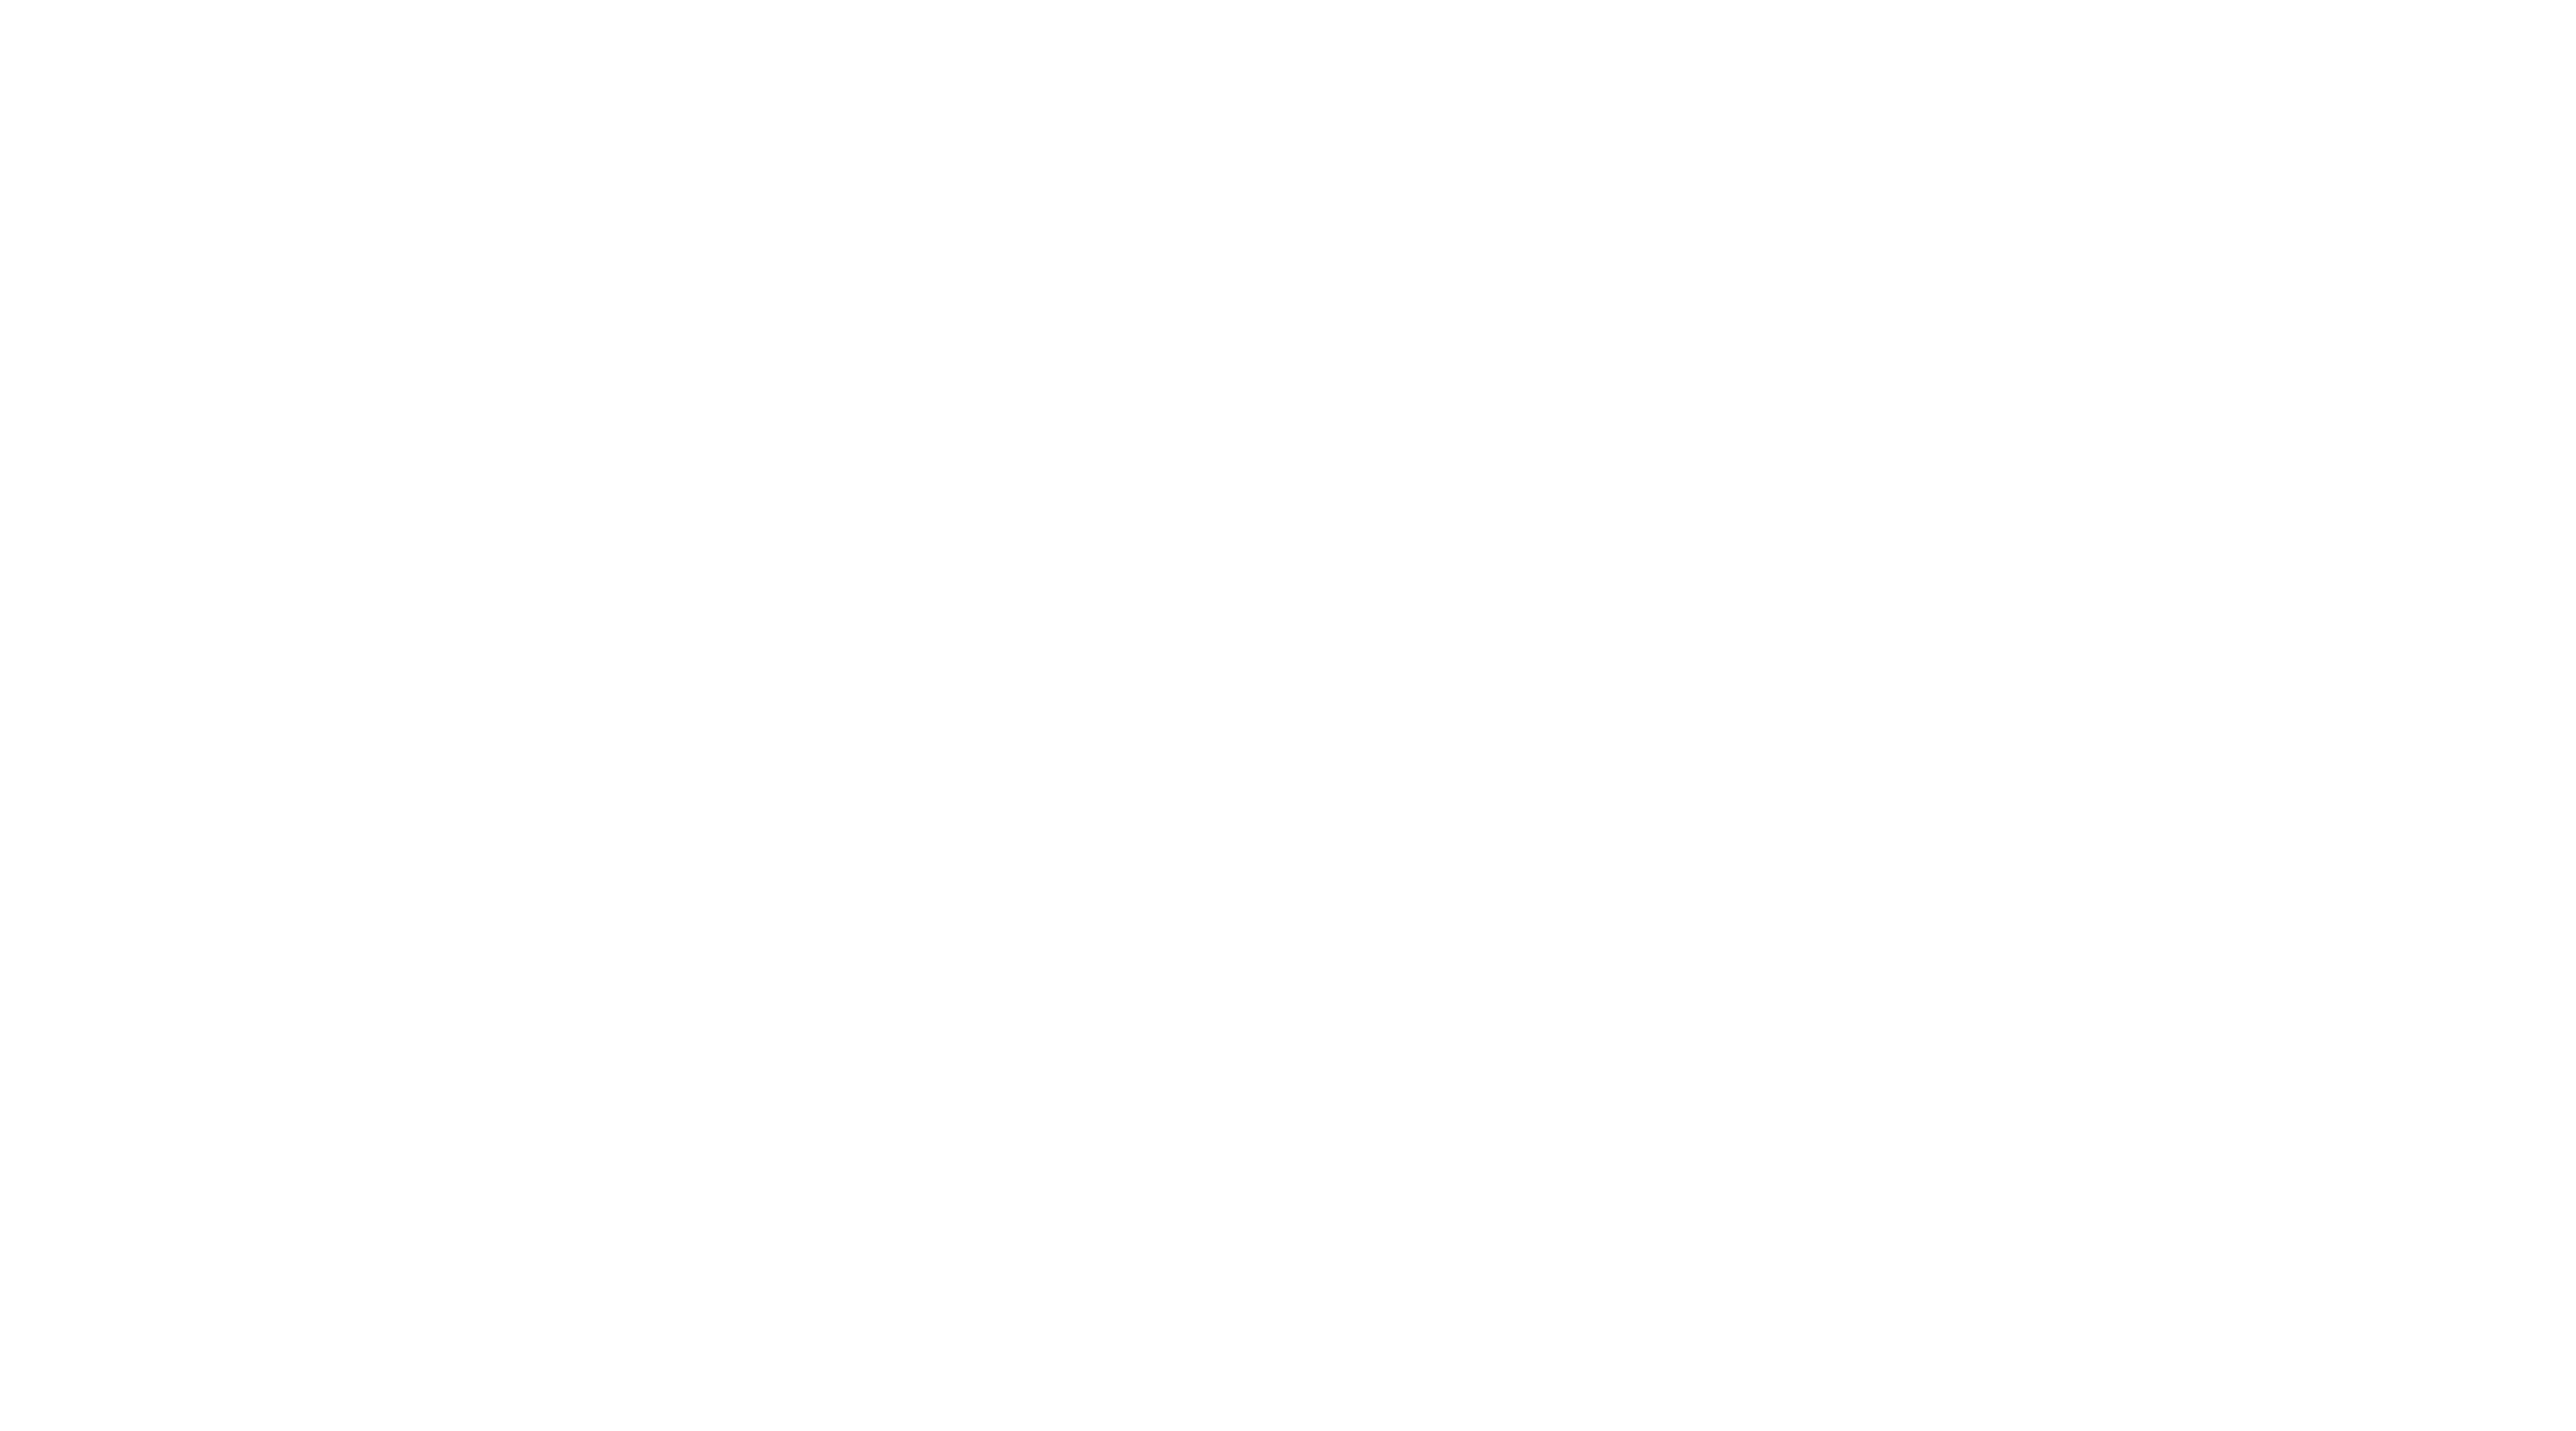

In [12]:

using CairoMakie
fig = Figure(size=(1800, 1000))

In [13]:
# Animation setup
n = Observable(1)
b_slice = @lift interior(b_ts[$n], 1, :, :)
ζ_slice = @lift interior(ζ_ts[$n], 1, :, :)

v_slice = @lift interior(v_ts[$n], 1, :, :)
w_slice = @lift interior(w_ts[$n], 1, :, :)

title_text = @lift "Day $(round(times[$n]/day, digits=1))"

UndefVarError: UndefVarError: `w_ts` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [14]:
# Buoyancy plot
ax_b = Axis(fig[1, 1], title="Buoyancy", xlabel="y [m]", ylabel="z [m]")
hm_b = heatmap!(ax_b, y, z, b_slice, colorrange=(0, Δb), colormap=:thermal)
contour!(ax_b, y, z, b_slice, levels=10, color=:black, linewidth=0.5)
Colorbar(fig[1, 2], hm_b, label="Buoyancy [m s⁻²]")

# Vorticity plot
ax_ζ = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_ζ = heatmap!(ax_ζ, y, z, ζ_slice, colorrange=(-3e-3, 3e-3), colormap=:balance)
contour!(ax_ζ, y, z, b_slice, levels=10, color=:black, linewidth=0.5)  # Overlay buoyancy contours
Colorbar(fig[1, 4], hm_ζ, label="Vorticity [s⁻¹]")

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

UndefVarError: UndefVarError: `title_text` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [15]:
# y velocity (v)
ax_v = Axis(fig[1, 1], title="V", xlabel="y [m]", ylabel="z [m]")
hm_v = heatmap!(ax_v, y, z, v_slice, colorrange=(0, Δb), colormap=:thermal)
contour!(ax_v, y, z, v_slice, levels=10, color=:black, linewidth=0.5)
Colorbar(fig[1, 2], hm_b, label="V [m s⁻²]")

# Vorticity plot
ax_w = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_w = heatmap!(ax_w, y, z, w_slice, colorrange=(-3e-3, 3e-3), colormap=:balance)
contour!(ax_w, y, z, w_slice, levels=10, color=:black, linewidth=0.5)  # Overlay buoyancy contours
Colorbar(fig[1, 4], hm_w, label="Vorticity [s⁻¹]")

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

ArgumentError: ArgumentError: Incompatible input axes in `Contour.contour`.